# Visualising taxa abundance

In [15]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)

## Pre-process data

#### Metadata

In [2]:
get_meta_cols <- function(meta) {
    meta_cols <- colnames(meta)[grep("kit|flow_cell|instrument_id|site_supplying", colnames(meta))]
    to_exclude <- c("library_prep_kit", "hiseq_xtm_flow_cell_v2_5_id")
    meta_cols <- meta_cols[!(meta_cols %in% to_exclude)]
    return(meta_cols)
}


to_retain <- fread("data/samples_above_95_reads.txt")$npm_research_id

meta <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv") %>%
    filter(npm_research_id %in% to_retain)

meta_cols <- get_meta_cols(meta)

head(meta)

npm_research_id,multiplex_pool_id,supplier_id,gis_internal_sample_id,site_supplying_sample,year_of_birth,supplied_gender,self_reported_ethnicity,extraction_kit,date_of_dna_extraction,⋯,supplied_and_computed_gender_match,sop_agreement_for_coverage__14/_28_for_15x/30x,sample_life_cycle,current,source_cohort,original_supplier_id,duplicate_info,duplicate,duplicate_pair,removal_requested_by_supplier
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WHB10000,MUX9693,00358,HELIOS_00358_1,HELIOS,1982,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,Y,HELIOS VCF,Y,HELIOS,00358,Unknown,PASS,Unknown,Unknown
WHB10001,MUX9693,00359,HELIOS_00359_1,HELIOS,1979,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,Y,HELIOS VCF,Y,HELIOS,00359,Unknown,PASS,Unknown,Unknown
WHB10002,MUX9695,00360,HELIOS_00360_1,HELIOS,1970,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,N,HELIOS VCF,Y,HELIOS,00360,Unknown,PASS,Unknown,Unknown
WHB10003,MUX9694,00361,HELIOS_00361_1,HELIOS,1969,M,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,Y,HELIOS VCF,Y,HELIOS,00361,Unknown,PASS,Unknown,Unknown
WHB10005,MUX9694,00363,HELIOS_00363_1,HELIOS,1959,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,N,HELIOS VCF,Y,HELIOS,00363,Unknown,PASS,Unknown,Unknown
WHB10006,MUX9694,00364,HELIOS_00364_1,HELIOS,1955,F,Chinese,abGENIX Whole Blood Genomic DNA Extraction Kit,6/6/2019,⋯,Y,Y,HELIOS VCF,Y,HELIOS,00364,Unknown,PASS,Unknown,Unknown


#### Host metadata

In [3]:
host_meta <- read.csv("data/PathogenVsHostDB-2019-05-30.csv")

human_pathogens <- unique((host_meta %>% filter(Human == "Yes"))$Species)

head(host_meta)
head(human_pathogens)

,X,Type,Phylum,Class,Order,Family,Genus,Species,Human,Zoonotic,⋯,Genome,Gsize,ProteinCount,PercentGC,HostSpeciesPHB,HostSpecies.new,N.genomes,Genome.size,Genome.GC,Genome.genes
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
1,1,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinobaculum,Actinobaculum massiliense,Yes,No,⋯,NA,NA,NA,NA,Homosapiens,Homo sapiens,1,2.065190,60.2,1784
2,2,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinobaculum,Actinobaculum suis,No,No,⋯,NA,NA,NA,NA,Susscrofadomesticus,Sus scrofa domesticus,4,2.277433,57.8,1852
3,3,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces bovis,Yes,Yes,⋯,NA,NA,NA,NA,Homosapiens,Homo sapiens,1,2.595570,64.1,2199
4,4,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces bovis,Yes,Yes,⋯,NA,NA,NA,NA,Oviscanadensis,Ovis canadensis,1,2.595570,64.1,2199
5,5,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces bovis,Yes,Yes,⋯,NA,NA,NA,NA,Ovisdalli,Ovis dalli,1,2.595570,64.1,2199
6,6,Bacteria,Actinobacteria,Actinobacteria,Actinomycetales,Actinomycetaceae,Actinomyces,Actinomyces bovis,Yes,Yes,⋯,NA,NA,NA,NA,Bostaurus,Bos taurus,1,2.595570,64.1,2199


[1] "Actinobaculum massiliense" "Actinomyces bovis"        
[3] "Actinomyces cardiffensis"  "Actinomyces dentalis"     
[5] "Actinomyces europaeus"     "Actinomyces funkei"

#### Abundance matrix

In [4]:
load_data <- function(file_path) {
    df <- fread(file_path) %>%
        separate(sample, into = c(NA, "npm_research_id"), sep = "\\.")
    return(df)
}

In [69]:
rank <- "S"
n_subset <- 9999

species_df <- load_data(str_glue("data/temp_files_{n_subset}/07_abundance_matrix/abundance_matrix.subset_{n_subset}.{rank}.tsv")) %>%
    filter(npm_research_id %in% to_retain) %>%
    select(-unclassified, -"Homo sapiens")
    

species_t <- t(species_df %>% select(-npm_research_id))
species_t <- as.data.frame(species_t)
colnames(species_t) <- species_df$npm_research_id

#### Relative abundance

In [40]:
otu_to_RA <- function(dat) {
    dat <- as.data.frame(dat)
    mat <- as.matrix(dat[, colnames(dat) != "npm_research_id"])
    RA_df <- as.data.frame(mat / rowSums(mat))
    RA_df <- add_column(RA_df, dat$npm_research_id, .before = 1)
    colnames(RA_df)[1] <- "npm_research_id"
    
    return(RA_df)
}


species_RA <- otu_to_RA(species_df)

#### Prevalence

In [46]:
species_prev <- species_df[, 2:ncol(species_df)]
species_prev[species_prev > 0] <- 1
species_prev <- add_column(species_prev, npm_research_id = species_df$npm_research_id, .before = 1)
head(species_prev)

npm_research_id,Paraburkholderia fungorum,Paraburkholderia xenovorans,Paraburkholderia hospita,Ralstonia pickettii,Ralstonia insidiosa,Ralstonia mannitolilytica,Ralstonia solanacearum,Burkholderia cepacia,Burkholderia sp. LA-2-3-30-S1-D2,⋯,Mycobacterium virus Che12,Grapevine Cabernet Sauvignon reovirus,Delftia phage IME-DE1,Fowlpox virus,Bacillus sp. Pc3,Agrotis segetum nucleopolyhedrovirus B,Vibrio phage 11895-B1,Mycobacterium phage Milly,Cacao swollen shoot Togo A virus,Streptomyces phage phiSASD1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WHB669,1,1,1,1,1,1,1,1,1,⋯,0,0,0,0,0,0,0,0,0,0
WHB8678,1,0,0,1,1,0,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
WHH7080,1,0,0,1,1,1,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WHB4818,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
WHB9470,1,0,1,1,1,1,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
WHB4637,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


#### CLR transform

In [42]:
RA_to_clr <- function(df) {
    row_names <- df$npm_research_id
    clr_df <- clr(df %>% select(where(is.numeric)))
    return(cbind(data.frame(npm_research_id = row_names), as.data.frame(clr_df, check.names = F)))
}

species_clr <- RA_to_clr(species_RA)
head(species_clr)

,npm_research_id,Paraburkholderia fungorum,Paraburkholderia xenovorans,Paraburkholderia hospita,Ralstonia pickettii,Ralstonia insidiosa,Ralstonia mannitolilytica,Ralstonia solanacearum,Burkholderia cepacia,Burkholderia sp. LA-2-3-30-S1-D2,⋯,Mycobacterium virus Che12,Grapevine Cabernet Sauvignon reovirus,Delftia phage IME-DE1,Fowlpox virus,Bacillus sp. Pc3,Agrotis segetum nucleopolyhedrovirus B,Vibrio phage 11895-B1,Mycobacterium phage Milly,Cacao swollen shoot Togo A virus,Streptomyces phage phiSASD1
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,WHB669,4.78256166,0.1004304,0.1004304,3.2991036,0.5058955,0.10043043,-0.59271675,0.1004304,-0.5927167,⋯,0,0,0,0,0,0,0,0,0,0
2,WHB8678,-0.07251289,0.0000000,0.0000000,0.7747850,2.5177543,0.00000000,-0.07251289,0.4383127,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0
3,WHH7080,-0.77793530,0.0000000,0.0000000,-0.7779353,0.8315026,-0.08478812,-0.08478812,0.0000000,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0
4,WHB4818,0.00000000,0.0000000,0.0000000,0.0000000,0.4173003,0.00000000,0.00000000,0.0000000,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0
5,WHB9470,-0.24787608,0.0000000,-0.9410233,1.0048869,1.1384183,0.44527110,1.36156183,-0.2478761,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0
6,WHB4637,0.00000000,0.0000000,0.0000000,0.0000000,0.1290949,0.00000000,0.00000000,0.0000000,0.0000000,⋯,0,0,0,0,0,0,0,0,0,0


### Get rare species

In [77]:
sample_counts <- t(species_prev %>% 
    summarise_if(is.numeric, sum)) 
sample_prev <- as.data.frame(sample_counts) %>%
    rownames_to_column("taxa") %>%
    rename(n_samples = V1) %>%
    mutate(prevalence = n_samples / nrow(species_df))

In [73]:
species_long <- species_df %>%  
    select(-npm_research_id) %>%
    pivot_longer(everything(), names_to = "taxa", values_to = "read_count") %>%
    filter(read_count != 0) %>% 
    arrange(desc(read_count))

stat_df <- species_long %>%
    group_by(taxa) %>%
    summarise(median = median(read_count), min = min(read_count), max = max(read_count)) %>%
    arrange(desc(median))

In [78]:
sample_prev %>%
    left_join(stat_df) %>%
    filter(prevalence < 0.05) %>%
    arrange(desc(max))

Joining, by = "taxa"



taxa,n_samples,prevalence,median,min,max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Fusobacterium nucleatum,362,0.0414757104,1.0,1,194777
Ureaplasma urealyticum,32,0.0036663611,3.0,1,20186
Rickettsia felis,87,0.0099679193,1.0,1,11403
Human betaherpesvirus 6A,96,0.0109990834,3.5,1,8777
Human betaherpesvirus 6B,139,0.0159257562,2.0,1,8491
Akkermansia muciniphila,322,0.0368927589,1.0,1,6137
Fusobacterium periodonticum,263,0.0301329056,1.0,1,4777
Hepatitis B virus,14,0.0016040330,2.5,1,4237
Ureaplasma parvum,94,0.0107699358,1.0,1,3317


In [13]:
species_long <- species_clr %>%
    pivot_longer(where(is.numeric), names_to = "taxa", values_to = "clr") %>%
    left_join(meta %>% select(all_of(c("npm_research_id", meta_cols))))


Joining, by = "npm_research_id"



In [14]:
bin <- ">5000"
to_plot <- bin_df %>% 
    filter(read_bins == bin) %>%
    distinct(taxa)

to_plot <- to_plot$taxa
to_plot

[1] "Ralstonia pickettii"          "Ralstonia insidiosa"         
 [3] "Burkholderia contaminans"     "Paracoccus yeei"             
 [5] "Achromobacter denitrificans"  "Achromobacter xylosoxidans"  
 [7] "Achromobacter spanius"        "Stenotrophomonas maltophilia"
 [9] "Pseudomonas mendocina"        "Pseudomonas aeruginosa"      
[11] "Pseudomonas putida"           "Pseudomonas stutzeri"        
[13] "Enterobacter cloacae"         "Microbacterium paraoxydans"  
[15] "Alcaligenes faecalis"         "Pseudomonas fluorescens"     
[17] "Acinetobacter johnsonii"      "Acinetobacter baumannii"     
[19] "Burkholderia lata"            "Pseudomonas fulva"           
[21] "Staphylococcus epidermidis"   "Human mastadenovirus C"      
[23] "Human betaherpesvirus 6B"     "Staphylococcus haemolyticus" 
[25] "Fusobacterium nucleatum"      "Staphylococcus cohnii"       
[27] "Pseudomonas alcaligenes"      "Haemophilus parainfluenzae"  
[29] "Gordonia terrae"              "Bacillus cereus"             
[31] "Neisseria subflava"           "Human betaherpesvirus 6A"    
[33] "Rickettsia felis"             "Ureaplasma urealyticum"

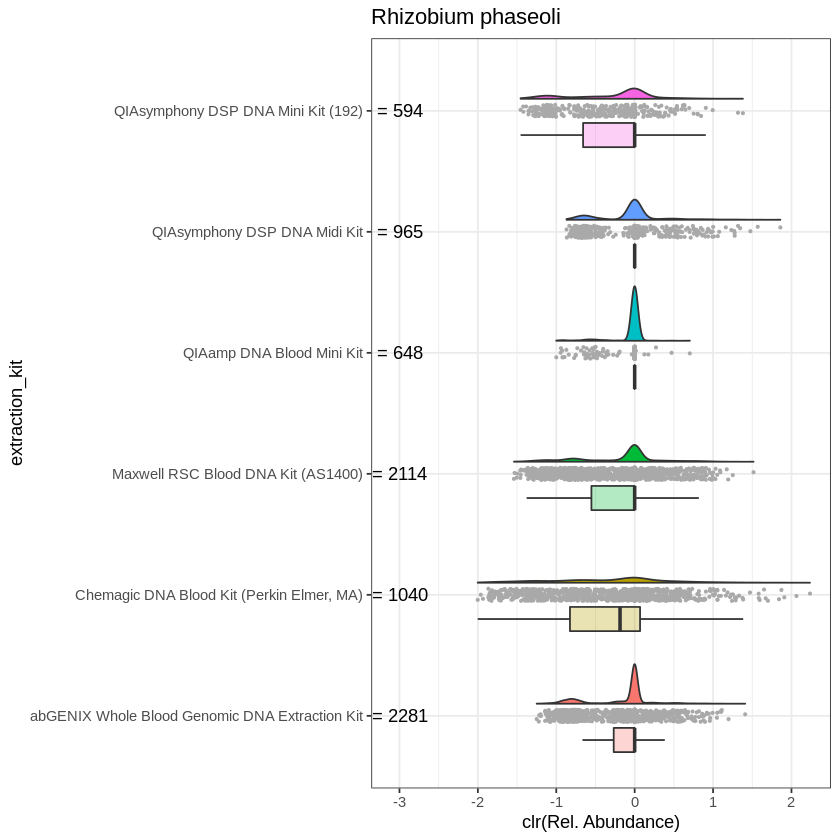

In [15]:
taxon <- "Rhizobium phaseoli"
column <- "extraction_kit"
label_pos <- min(species_long$clr) - 0.5

n_fun <- function(x){
  return(data.frame(y = label_pos, label = paste0("n = ", length(x))))
}

species_long %>%
    filter(taxa == taxon, get(column) != "Unknown") %>%
    ggplot(aes(x = get(column), y = clr, fill = get(column))) +
        theme_bw() +
        geom_boxplot(position = position_nudge(x = -0.2, y = 0), 
                   width = 0.2, 
                   outlier.shape = NA,
                   alpha = 0.3) +
        geom_violinhalf(position = position_nudge(x = 0.1, y = 0), alpha = 1) +
        geom_point(position = position_jitter(width = 0.05), 
                   color = "dark grey",
                     size = 0.5, 
                     alpha = 1) +
        stat_summary(fun.data = n_fun, geom = "text") +
        labs(x = column, y = "clr(Rel. Abundance)", title = taxon) +
        coord_flip() +
        theme(legend.position = "none")



#### Plot abundance distribution

In [16]:
label_pos <- min(species_long$clr) - 0.5

n_fun <- function(x){
  return(data.frame(y = label_pos, label = paste0("n = ", length(x))))
}

In [17]:
for (column in meta_cols) {
    plots_without_zeros <- foreach (taxon = to_plot) %dopar% {
        species_long %>%
    filter(taxa == taxon, clr != 0, get(column) != "Unknown") %>%
            ggplot(aes(x = get(column), y = clr, fill = get(column))) +
                theme_bw() +
                geom_boxplot(position = position_nudge(x = -0.2, y = 0), 
                           width = 0.2, 
                           outlier.shape = NA,
                           alpha = 0.3) +
                geom_violinhalf(position = position_nudge(x = 0.1, y = 0), alpha = 1) +
                geom_point(position = position_jitter(width = 0.05), 
                           color = "dark grey",
                             size = 0.5, 
                             alpha = 1) +
                stat_summary(fun.data = n_fun, geom = "text") +
                labs(x = column, y = "clr(Rel. Abundance)", title = taxon) +
                coord_flip() +
                theme(legend.position = "none")
    }


    pdf(str_glue("results/outliers/without_zeroes/clr_abundance.{column}.without_zeroes.pdf"))

        for (plt in plots_without_zeros) {
            print(plt)
        }

    dev.off()
    
    stopImplicitCluster()
}


Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”

Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Groups with fewer than two data points have been dropped.”

In [18]:
for (column in meta_cols) {
    plots_with_zeros <- foreach (taxon = to_plot) %dopar% {
        species_long %>%
    filter(taxa == taxon, get(column) != "Unknown") %>%
            ggplot(aes(x = get(column), y = clr, fill = get(column))) +
                theme_bw() +
                geom_boxplot(position = position_nudge(x = -0.2, y = 0), 
                           width = 0.2, 
                           outlier.shape = NA,
                           alpha = 0.3) +
                geom_violinhalf(position = position_nudge(x = 0.1, y = 0), alpha = 1) +
                geom_point(position = position_jitter(width = 0.05), 
                           color = "dark grey",
                             size = 0.5, 
                             alpha = 1) +
                stat_summary(fun.data = n_fun, geom = "text") +
                labs(x = column, y = "clr(Rel. Abundance)", title = taxon) +
                coord_flip() +
                theme(legend.position = "none")
    }


    pdf(str_glue("results/outliers/with_zeroes/clr_abundance.{column}.with_zeroes.pdf"))

        for (plt in plots_with_zeros) {
            print(plt)
        }

    dev.off()
    
    stopImplicitCluster()
}
